In [51]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras import layers
from keras.layers import *
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from scipy.io import loadmat

In [52]:
data = loadmat('jaffe_mean_data.mat')['jaffe_mean_data']

In [53]:
data = data.reshape((181,256,256,1))

In [54]:
label = loadmat('cl_label.mat')['cl_label']

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2)

In [56]:
print('Training: ',X_train.shape)

Training:  (144, 256, 256, 1)


In [57]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

In [58]:
from keras.models import Sequential

In [59]:
def get_nn_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size = (4,4), strides=None,input_shape=(256,256,1)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [60]:
def get_cnn_model():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), padding='same',input_shape=(256,256,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [61]:
cnn_model = get_cnn_model()

In [62]:
nn_model = get_nn_model()

In [63]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_15 (MaxPooling (None, 64, 64, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               524416    
_________________________________________________________________
batch_normalization_25 (Batc (None, 128)               512       
_________________________________________________________________
activation_30 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
__________

In [64]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_23 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 128)     73856     
__________

In [65]:
from keras.preprocessing.image import ImageDataGenerator 

In [66]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [67]:
from keras import backend as K

In [68]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [69]:
def train_cnn_model(model):
    filepath='../opt/jaffe-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 16

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [70]:
def train_nn_model(model):
    filepath='../opt/jaffe-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [71]:
 cnn_history, cnn_model = train_cnn_model(cnn_model)

Epoch 1/200
9/9 [==============================] - 8s 836ms/step - loss: 2.6183 - fbeta: 0.0903 - acc: 0.1667 - val_loss: 9.9858 - val_fbeta: 0.2464 - val_acc: 0.2464

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.2464.hdf5

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.2464.hdf5
Epoch 2/200
9/9 [==============================] - 2s 220ms/step - loss: 2.4519 - fbeta: 0.1042 - acc: 0.2569 - val_loss: 9.7768 - val_fbeta: 0.2143 - val_acc: 0.2143

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.2143.hdf5

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.2143.hdf5
Epoch 3/200
9/9 [==============================] - 2s 226ms/step - loss: 2.1987 - fbeta: 0.1528 - acc: 0.3194 - val_loss: 5.1517 - val_fbeta: 0.2029 - val_acc: 0.2029

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.2029.hdf5

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.2029.hdf5
Epoch 4/200
9/9 [==============================] - 2s 218ms/step - loss: 1.9173 - fbeta: 0.

Epoch 28/200
9/9 [==============================] - 2s 219ms/step - loss: 0.3995 - fbeta: 0.8611 - acc: 0.8750 - val_loss: 1.2232 - val_fbeta: 0.4762 - val_acc: 0.5238

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.5238.hdf5

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.5238.hdf5
Epoch 29/200
9/9 [==============================] - 2s 228ms/step - loss: 0.3614 - fbeta: 0.8472 - acc: 0.8750 - val_loss: 0.9039 - val_fbeta: 0.5507 - val_acc: 0.6522

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.6522.hdf5

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.6522.hdf5
Epoch 30/200
9/9 [==============================] - 2s 218ms/step - loss: 0.3370 - fbeta: 0.8611 - acc: 0.8958 - val_loss: 1.0457 - val_fbeta: 0.5238 - val_acc: 0.6190

Epoch 00030: saving model to ../opt/jaffe-cnn/Model.30-0.6190.hdf5

Epoch 00030: saving model to ../opt/jaffe-cnn/Model.30-0.6190.hdf5
Epoch 31/200
9/9 [==============================] - 2s 227ms/step - loss: 0.2626 - fbeta

Epoch 55/200
9/9 [==============================] - 2s 227ms/step - loss: 0.1576 - fbeta: 0.9444 - acc: 0.9444 - val_loss: 0.4536 - val_fbeta: 0.8696 - val_acc: 0.8696

Epoch 00055: saving model to ../opt/jaffe-cnn/Model.55-0.8696.hdf5

Epoch 00055: saving model to ../opt/jaffe-cnn/Model.55-0.8696.hdf5
Epoch 56/200
9/9 [==============================] - 2s 221ms/step - loss: 0.0955 - fbeta: 0.9583 - acc: 0.9653 - val_loss: 0.3630 - val_fbeta: 0.9524 - val_acc: 0.9524

Epoch 00056: saving model to ../opt/jaffe-cnn/Model.56-0.9524.hdf5

Epoch 00056: saving model to ../opt/jaffe-cnn/Model.56-0.9524.hdf5
Epoch 57/200
9/9 [==============================] - 2s 226ms/step - loss: 0.0606 - fbeta: 0.9861 - acc: 0.9931 - val_loss: 0.2692 - val_fbeta: 0.9275 - val_acc: 0.9420

Epoch 00057: saving model to ../opt/jaffe-cnn/Model.57-0.9420.hdf5

Epoch 00057: saving model to ../opt/jaffe-cnn/Model.57-0.9420.hdf5
Epoch 58/200
9/9 [==============================] - 2s 219ms/step - loss: 0.1047 - fbeta

Epoch 82/200
9/9 [==============================] - 2s 219ms/step - loss: 0.0650 - fbeta: 0.9931 - acc: 0.9931 - val_loss: 0.3305 - val_fbeta: 0.9524 - val_acc: 0.9524

Epoch 00082: saving model to ../opt/jaffe-cnn/Model.82-0.9524.hdf5

Epoch 00082: saving model to ../opt/jaffe-cnn/Model.82-0.9524.hdf5
Epoch 83/200
9/9 [==============================] - 2s 228ms/step - loss: 0.0655 - fbeta: 0.9792 - acc: 0.9861 - val_loss: 0.3687 - val_fbeta: 0.9420 - val_acc: 0.9420

Epoch 00083: saving model to ../opt/jaffe-cnn/Model.83-0.9420.hdf5

Epoch 00083: saving model to ../opt/jaffe-cnn/Model.83-0.9420.hdf5
Epoch 84/200
9/9 [==============================] - 2s 218ms/step - loss: 0.0312 - fbeta: 0.9931 - acc: 0.9931 - val_loss: 0.3165 - val_fbeta: 0.9524 - val_acc: 0.9524

Epoch 00084: saving model to ../opt/jaffe-cnn/Model.84-0.9524.hdf5

Epoch 00084: saving model to ../opt/jaffe-cnn/Model.84-0.9524.hdf5
Epoch 85/200
9/9 [==============================] - 2s 229ms/step - loss: 0.0496 - fbeta

Epoch 109/200
9/9 [==============================] - 2s 227ms/step - loss: 0.0709 - fbeta: 0.9722 - acc: 0.9792 - val_loss: 0.2468 - val_fbeta: 0.9565 - val_acc: 0.9565

Epoch 00109: saving model to ../opt/jaffe-cnn/Model.109-0.9565.hdf5

Epoch 00109: saving model to ../opt/jaffe-cnn/Model.109-0.9565.hdf5
Epoch 110/200
9/9 [==============================] - 2s 218ms/step - loss: 0.0331 - fbeta: 0.9931 - acc: 0.9931 - val_loss: 0.5800 - val_fbeta: 0.9286 - val_acc: 0.9286

Epoch 00110: saving model to ../opt/jaffe-cnn/Model.110-0.9286.hdf5

Epoch 00110: saving model to ../opt/jaffe-cnn/Model.110-0.9286.hdf5
Epoch 111/200
9/9 [==============================] - 2s 226ms/step - loss: 0.0385 - fbeta: 0.9861 - acc: 0.9861 - val_loss: 0.3964 - val_fbeta: 0.9420 - val_acc: 0.9420

Epoch 00111: saving model to ../opt/jaffe-cnn/Model.111-0.9420.hdf5

Epoch 00111: saving model to ../opt/jaffe-cnn/Model.111-0.9420.hdf5
Epoch 112/200
9/9 [==============================] - 2s 218ms/step - loss: 0.08


Epoch 00135: saving model to ../opt/jaffe-cnn/Model.135-0.9420.hdf5
Epoch 136/200
9/9 [==============================] - 2s 221ms/step - loss: 0.0626 - fbeta: 0.9792 - acc: 0.9792 - val_loss: 0.3299 - val_fbeta: 0.9524 - val_acc: 0.9524

Epoch 00136: saving model to ../opt/jaffe-cnn/Model.136-0.9524.hdf5

Epoch 00136: saving model to ../opt/jaffe-cnn/Model.136-0.9524.hdf5
Epoch 137/200
9/9 [==============================] - 2s 227ms/step - loss: 0.0497 - fbeta: 0.9722 - acc: 0.9722 - val_loss: 0.3967 - val_fbeta: 0.9420 - val_acc: 0.9420

Epoch 00137: saving model to ../opt/jaffe-cnn/Model.137-0.9420.hdf5

Epoch 00137: saving model to ../opt/jaffe-cnn/Model.137-0.9420.hdf5
Epoch 138/200
9/9 [==============================] - 2s 219ms/step - loss: 0.0724 - fbeta: 0.9792 - acc: 0.9861 - val_loss: 0.3314 - val_fbeta: 0.9524 - val_acc: 0.9524

Epoch 00138: saving model to ../opt/jaffe-cnn/Model.138-0.9524.hdf5

Epoch 00138: saving model to ../opt/jaffe-cnn/Model.138-0.9524.hdf5
Epoch 139/


Epoch 00162: saving model to ../opt/jaffe-cnn/Model.162-0.9286.hdf5

Epoch 00162: saving model to ../opt/jaffe-cnn/Model.162-0.9286.hdf5
Epoch 163/200
9/9 [==============================] - 2s 227ms/step - loss: 0.0631 - fbeta: 0.9792 - acc: 0.9792 - val_loss: 0.4010 - val_fbeta: 0.9420 - val_acc: 0.9420

Epoch 00163: saving model to ../opt/jaffe-cnn/Model.163-0.9420.hdf5

Epoch 00163: saving model to ../opt/jaffe-cnn/Model.163-0.9420.hdf5
Epoch 164/200
9/9 [==============================] - 2s 221ms/step - loss: 0.0362 - fbeta: 0.9931 - acc: 0.9931 - val_loss: 0.3198 - val_fbeta: 0.9524 - val_acc: 0.9524

Epoch 00164: saving model to ../opt/jaffe-cnn/Model.164-0.9524.hdf5

Epoch 00164: saving model to ../opt/jaffe-cnn/Model.164-0.9524.hdf5
Epoch 165/200
9/9 [==============================] - 2s 227ms/step - loss: 0.0551 - fbeta: 0.9792 - acc: 0.9861 - val_loss: 0.4089 - val_fbeta: 0.9420 - val_acc: 0.9420

Epoch 00165: saving model to ../opt/jaffe-cnn/Model.165-0.9420.hdf5

Epoch 001

9/9 [==============================] - 2s 227ms/step - loss: 0.0441 - fbeta: 0.9861 - acc: 0.9861 - val_loss: 0.3669 - val_fbeta: 0.9565 - val_acc: 0.9565

Epoch 00189: saving model to ../opt/jaffe-cnn/Model.189-0.9565.hdf5

Epoch 00189: saving model to ../opt/jaffe-cnn/Model.189-0.9565.hdf5
Epoch 190/200
9/9 [==============================] - 2s 220ms/step - loss: 0.0698 - fbeta: 0.9653 - acc: 0.9722 - val_loss: 0.3957 - val_fbeta: 0.9286 - val_acc: 0.9286

Epoch 00190: saving model to ../opt/jaffe-cnn/Model.190-0.9286.hdf5

Epoch 00190: saving model to ../opt/jaffe-cnn/Model.190-0.9286.hdf5
Epoch 191/200
9/9 [==============================] - 2s 227ms/step - loss: 0.0499 - fbeta: 0.9861 - acc: 0.9861 - val_loss: 0.3980 - val_fbeta: 0.9420 - val_acc: 0.9420

Epoch 00191: saving model to ../opt/jaffe-cnn/Model.191-0.9420.hdf5

Epoch 00191: saving model to ../opt/jaffe-cnn/Model.191-0.9420.hdf5
Epoch 192/200
9/9 [==============================] - 2s 221ms/step - loss: 0.0317 - fbeta: 1.

In [72]:
nn_history, nn_model = train_nn_model(nn_model)

Epoch 1/200
5/4 [=================================] - 2s 351ms/step - loss: 2.6067 - fbeta: 0.0382 - acc: 0.1377 - val_loss: 2.5807 - val_fbeta: 1.7838e-07 - val_acc: 0.1081

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.1081.hdf5

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.1081.hdf5
Epoch 2/200
5/4 [=================================] - 0s 12ms/step - loss: 2.4243 - fbeta: 0.0637 - acc: 0.1453 - val_loss: 2.3663 - val_fbeta: 0.0270 - val_acc: 0.1081

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.1081.hdf5

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.1081.hdf5
Epoch 3/200
5/4 [=================================] - 0s 11ms/step - loss: 2.2305 - fbeta: 0.0509 - acc: 0.1962 - val_loss: 2.3605 - val_fbeta: 0.0270 - val_acc: 0.0811

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.0811.hdf5

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.0811.hdf5
Epoch 4/200
5/4 [=================================] - 0s 11ms/step - loss: 2.2170 - fb

Epoch 28/200
5/4 [=================================] - 0s 12ms/step - loss: 0.8048 - fbeta: 0.5752 - acc: 0.7245 - val_loss: 0.8988 - val_fbeta: 0.5405 - val_acc: 0.7297

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.7297.hdf5

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.7297.hdf5
Epoch 29/200
5/4 [=================================] - 0s 12ms/step - loss: 0.7747 - fbeta: 0.5880 - acc: 0.7766 - val_loss: 0.9655 - val_fbeta: 0.4324 - val_acc: 0.6486

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.6486.hdf5

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.6486.hdf5
Epoch 30/200
5/4 [=================================] - 0s 12ms/step - loss: 0.8282 - fbeta: 0.5278 - acc: 0.7662 - val_loss: 0.8690 - val_fbeta: 0.5405 - val_acc: 0.7568

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.7568.hdf5

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.7568.hdf5
Epoch 31/200
5/4 [=================================] - 0s 12ms/step - loss: 0.6456 - fbe

Epoch 55/200
5/4 [=================================] - 0s 11ms/step - loss: 0.4796 - fbeta: 0.7830 - acc: 0.8582 - val_loss: 0.6668 - val_fbeta: 0.7568 - val_acc: 0.8649

Epoch 00055: saving model to ../opt/jaffe-nn/Model.55-0.8649.hdf5

Epoch 00055: saving model to ../opt/jaffe-nn/Model.55-0.8649.hdf5
Epoch 56/200
5/4 [=================================] - 0s 11ms/step - loss: 0.3749 - fbeta: 0.8275 - acc: 0.8785 - val_loss: 0.6213 - val_fbeta: 0.7297 - val_acc: 0.7838

Epoch 00056: saving model to ../opt/jaffe-nn/Model.56-0.7838.hdf5

Epoch 00056: saving model to ../opt/jaffe-nn/Model.56-0.7838.hdf5
Epoch 57/200
5/4 [=================================] - 0s 12ms/step - loss: 0.4489 - fbeta: 0.7674 - acc: 0.8426 - val_loss: 0.7393 - val_fbeta: 0.6216 - val_acc: 0.7027

Epoch 00057: saving model to ../opt/jaffe-nn/Model.57-0.7027.hdf5

Epoch 00057: saving model to ../opt/jaffe-nn/Model.57-0.7027.hdf5
Epoch 58/200
5/4 [=================================] - 0s 11ms/step - loss: 0.3054 - fbe

Epoch 00081: saving model to ../opt/jaffe-nn/Model.81-0.9189.hdf5
Epoch 82/200
5/4 [=================================] - 0s 12ms/step - loss: 0.1507 - fbeta: 0.9693 - acc: 0.9936 - val_loss: 0.3743 - val_fbeta: 0.8919 - val_acc: 0.8919

Epoch 00082: saving model to ../opt/jaffe-nn/Model.82-0.8919.hdf5

Epoch 00082: saving model to ../opt/jaffe-nn/Model.82-0.8919.hdf5
Epoch 83/200
5/4 [=================================] - 0s 12ms/step - loss: 0.2413 - fbeta: 0.9016 - acc: 0.9450 - val_loss: 0.4223 - val_fbeta: 0.8378 - val_acc: 0.8919

Epoch 00083: saving model to ../opt/jaffe-nn/Model.83-0.8919.hdf5

Epoch 00083: saving model to ../opt/jaffe-nn/Model.83-0.8919.hdf5
Epoch 84/200
5/4 [=================================] - 0s 11ms/step - loss: 0.2059 - fbeta: 0.9132 - acc: 0.9502 - val_loss: 0.3798 - val_fbeta: 0.8378 - val_acc: 0.8649

Epoch 00084: saving model to ../opt/jaffe-nn/Model.84-0.8649.hdf5

Epoch 00084: saving model to ../opt/jaffe-nn/Model.84-0.8649.hdf5
Epoch 85/200
5/4 [====


Epoch 00108: saving model to ../opt/jaffe-nn/Model.108-0.9189.hdf5
Epoch 109/200
5/4 [=================================] - 0s 13ms/step - loss: 0.1269 - fbeta: 0.9745 - acc: 1.0000 - val_loss: 0.3595 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00109: saving model to ../opt/jaffe-nn/Model.109-0.9459.hdf5

Epoch 00109: saving model to ../opt/jaffe-nn/Model.109-0.9459.hdf5
Epoch 110/200
5/4 [=================================] - 0s 12ms/step - loss: 0.1519 - fbeta: 0.9346 - acc: 0.9884 - val_loss: 0.3502 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00110: saving model to ../opt/jaffe-nn/Model.110-0.9459.hdf5

Epoch 00110: saving model to ../opt/jaffe-nn/Model.110-0.9459.hdf5
Epoch 111/200
5/4 [=================================] - 0s 12ms/step - loss: 0.1369 - fbeta: 0.9757 - acc: 0.9884 - val_loss: 0.2490 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00111: saving model to ../opt/jaffe-nn/Model.111-0.9459.hdf5

Epoch 00111: saving model to ../opt/jaffe-nn/Model.111-0.9459.hdf5
Epoch 112/2


Epoch 00135: saving model to ../opt/jaffe-nn/Model.135-0.9459.hdf5

Epoch 00135: saving model to ../opt/jaffe-nn/Model.135-0.9459.hdf5
Epoch 136/200
5/4 [=================================] - 0s 13ms/step - loss: 0.0881 - fbeta: 0.9873 - acc: 1.0000 - val_loss: 0.3496 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00136: saving model to ../opt/jaffe-nn/Model.136-0.9459.hdf5

Epoch 00136: saving model to ../opt/jaffe-nn/Model.136-0.9459.hdf5
Epoch 137/200
5/4 [=================================] - 0s 11ms/step - loss: 0.1163 - fbeta: 0.9757 - acc: 1.0000 - val_loss: 0.2611 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00137: saving model to ../opt/jaffe-nn/Model.137-0.9459.hdf5

Epoch 00137: saving model to ../opt/jaffe-nn/Model.137-0.9459.hdf5
Epoch 138/200
5/4 [=================================] - 0s 11ms/step - loss: 0.1265 - fbeta: 0.9618 - acc: 1.0000 - val_loss: 0.3275 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00138: saving model to ../opt/jaffe-nn/Model.138-0.9459.hdf5

Epoch 0013

5/4 [=================================] - 0s 11ms/step - loss: 0.1304 - fbeta: 0.9630 - acc: 0.9757 - val_loss: 0.2711 - val_fbeta: 0.8919 - val_acc: 0.9459

Epoch 00162: saving model to ../opt/jaffe-nn/Model.162-0.9459.hdf5

Epoch 00162: saving model to ../opt/jaffe-nn/Model.162-0.9459.hdf5
Epoch 163/200
5/4 [=================================] - 0s 10ms/step - loss: 0.1007 - fbeta: 0.9936 - acc: 0.9936 - val_loss: 0.2514 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00163: saving model to ../opt/jaffe-nn/Model.163-0.9459.hdf5

Epoch 00163: saving model to ../opt/jaffe-nn/Model.163-0.9459.hdf5
Epoch 164/200
5/4 [=================================] - 0s 12ms/step - loss: 0.1217 - fbeta: 0.9682 - acc: 0.9809 - val_loss: 0.2493 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00164: saving model to ../opt/jaffe-nn/Model.164-0.9459.hdf5

Epoch 00164: saving model to ../opt/jaffe-nn/Model.164-0.9459.hdf5
Epoch 165/200
5/4 [=================================] - 0s 12ms/step - loss: 0.1073 - fbeta: 


Epoch 00188: saving model to ../opt/jaffe-nn/Model.188-0.9459.hdf5
Epoch 189/200
5/4 [=================================] - 0s 11ms/step - loss: 0.1362 - fbeta: 0.9502 - acc: 0.9757 - val_loss: 0.2480 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00189: saving model to ../opt/jaffe-nn/Model.189-0.9459.hdf5

Epoch 00189: saving model to ../opt/jaffe-nn/Model.189-0.9459.hdf5
Epoch 190/200
5/4 [=================================] - 0s 13ms/step - loss: 0.1298 - fbeta: 0.9578 - acc: 0.9873 - val_loss: 0.2427 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00190: saving model to ../opt/jaffe-nn/Model.190-0.9459.hdf5

Epoch 00190: saving model to ../opt/jaffe-nn/Model.190-0.9459.hdf5
Epoch 191/200
5/4 [=================================] - 0s 12ms/step - loss: 0.1300 - fbeta: 0.9705 - acc: 0.9769 - val_loss: 0.3198 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00191: saving model to ../opt/jaffe-nn/Model.191-0.9459.hdf5

Epoch 00191: saving model to ../opt/jaffe-nn/Model.191-0.9459.hdf5
Epoch 192/2

In [73]:
n_classes = label.shape[1]

In [74]:
labels=range(n_classes)

In [75]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

1/1 [==============================] - 0s 117ms/step
Evaluation loss:  0.38797280192375183
Evaluation accuracy:  0.9459459185600281


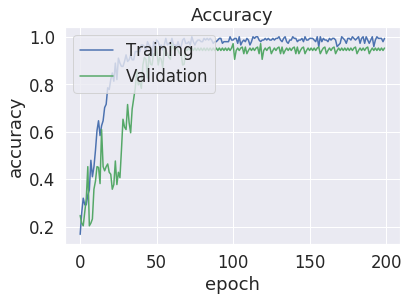

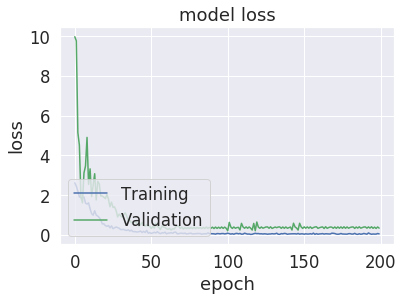

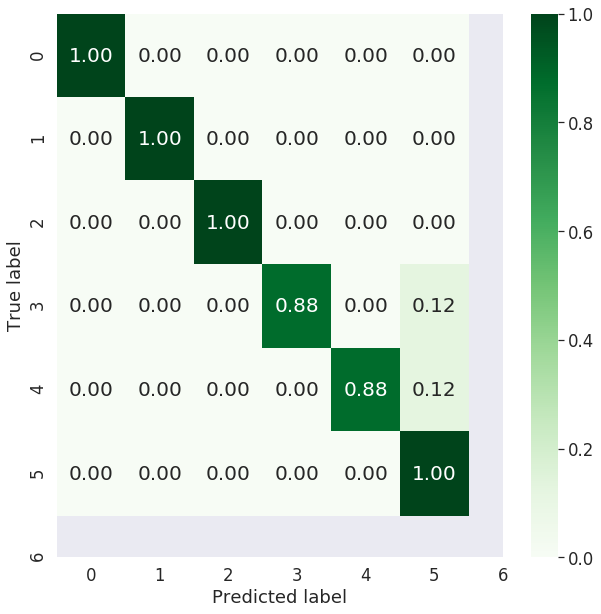

In [76]:
eval_model(cnn_history, cnn_model)

1/1 [==============================] - 0s 8ms/step
Evaluation loss:  0.3303302824497223
Evaluation accuracy:  0.9459459185600281


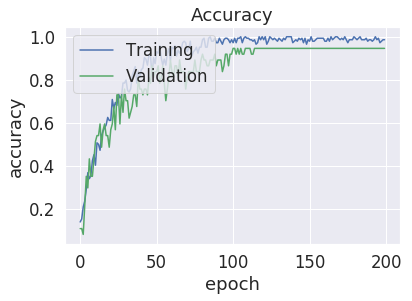

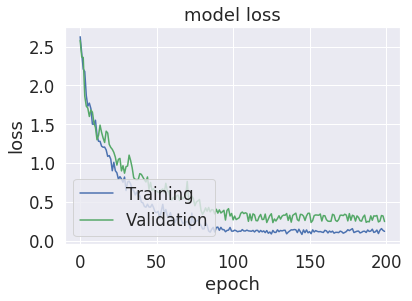

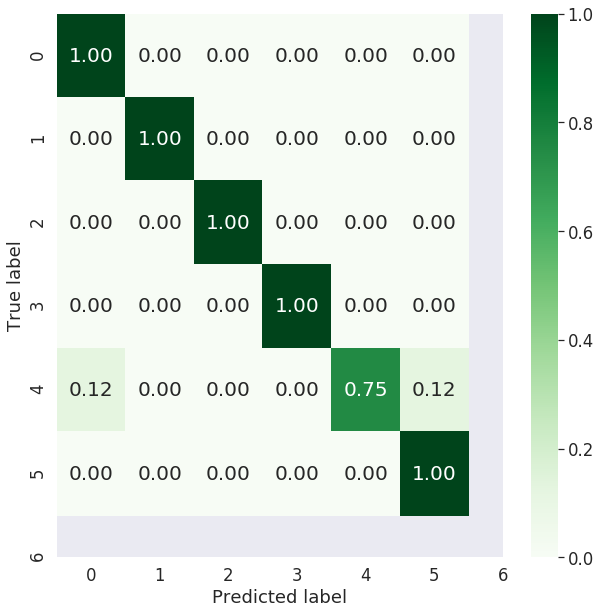

In [77]:
eval_model(nn_history, nn_model)